### 목표
- 신경망을 활용해서 다중분류에 필요한 keras의 기능을 활용해보자
- 이미지 데이터를 다루는 방법을 이해해보자
- 직접 손으로 쓴 글씨를 인식하는 것까지 연결해보자

In [90]:
# 환경 셋팅
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist

# 이미지 불러오기
(X_train, y_train),(X_test,y_test) = mnist.load_data()

In [91]:
# 크기확인
X_train.shape , X_test.shape

((60000, 28, 28), (10000, 28, 28))

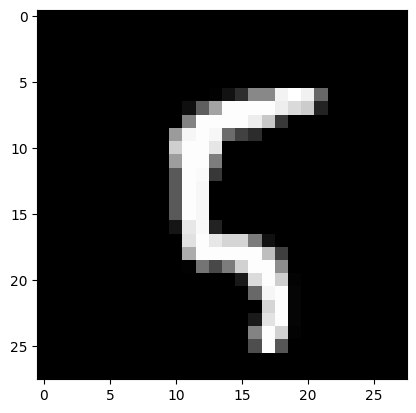

In [92]:
plt.imshow(X_train[100],cmap='gray')
plt.show()

0


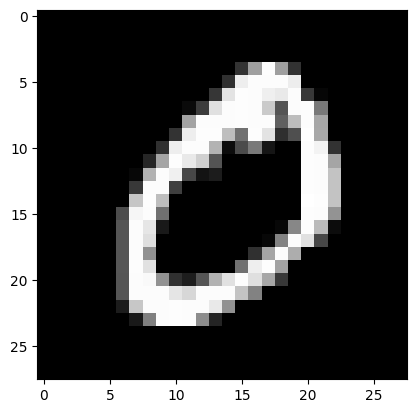

5


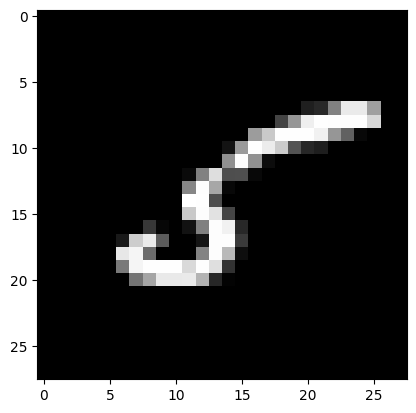

0


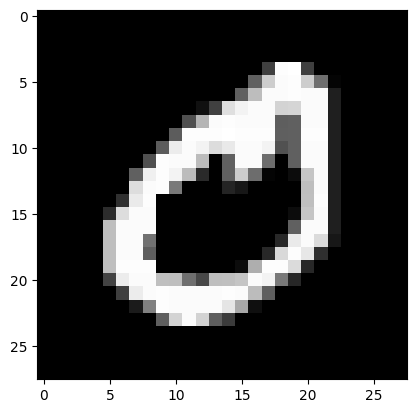

8


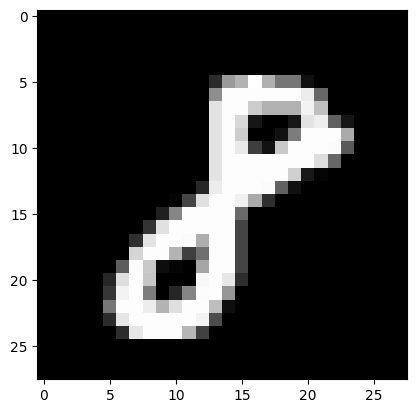

8


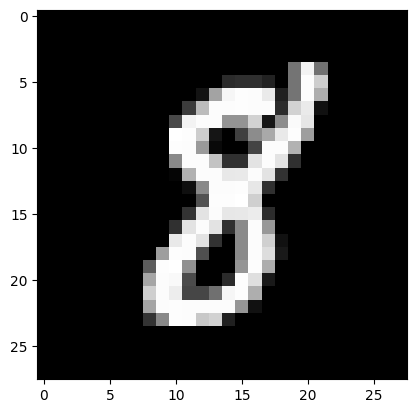

0


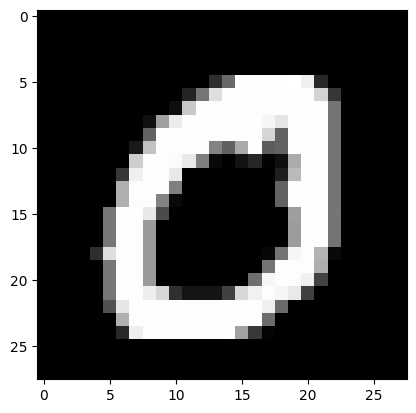

4


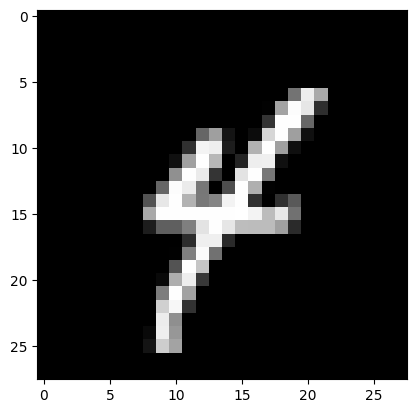

7


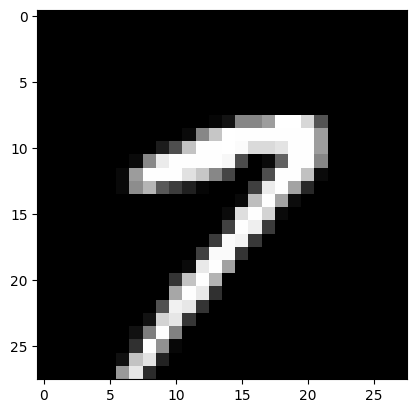

0


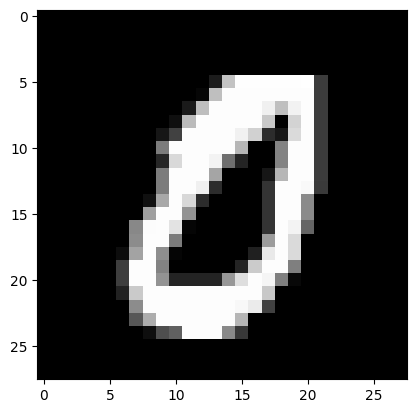

7


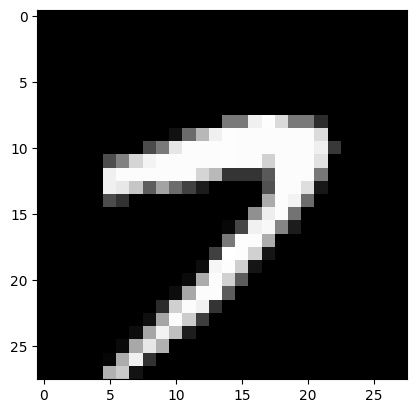

In [93]:
for i in range(1,100,10) :
  plt.imshow(X_train[i],cmap='gray')
  print(y_train[i])  # 해당 숫자까지 출력해주는 거
  plt.show()

In [94]:
# 이미지 크기 변경, 전처리
# mlp가 받아들이는 것은 1차원인데 우리가 가지고 있는 이미지는 2차원
# -> 1차원 변환(flatten 이용하기)

X_train2 = X_train.reshape(60000,28*28 )  # 28*28은 행열 구분 안하겠다 곱해주겠다!
X_test2 = X_test.reshape(10000,28*28)

# + 분산 줄여주기도 함
# 이미지 흑~백 : 0 ~ 255 사이의 값으로 표현이 되어있음
# 0 ~ 1 사이를 줄여두는 작업도 있다. => 변형을 하기도함
# X_train2 / 255.0 => 0 ~ 1

# 크기 확인
X_train2.shape , X_test2.shape



((60000, 784), (10000, 784))

In [95]:
# 클래스 개수 확인하기
np.unique(y_train).size  # 10개
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [96]:
# 원 핫 인코딩
# 판다스 -> get_dummies
# tensorflow -> to_categorical 을 써도 된다 

from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
print(y_train_oh.shape, y_test_oh.shape)

(60000, 10) (10000, 10)


In [97]:
y_train[0]

5

MLP 신경망 설게

In [98]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [99]:
# add() :  신경망에 층을 추가
# Dense() : 층을 정의 (퍼셉트론의 수, 입력의 수, 활성화 함수)
# input_dim , input_shape : 다차원 데이터를 입력으로 받거나 1차원 데이터를 입력으로 받을때
# 특성의 수 - 픽셀의 수(이미지데이터에서는 이렇게 표현할 수 있음)
#         이 이미지 데이터의 크기는 어느정도일까? 28 28
model_mlp = Sequential()
# 여기서는 falatten 사용 안해도됨
# 입력 + 중간층
model_mlp.add(Dense(600 , input_dim = 784, activation = 'relu'))
#  은닉층(중간층)
model_mlp.add(Dense(300, activation = 'relu' ))
model_mlp.add(Dense(50, activation = 'relu' ))
# 출력층
# 회귀분석
#   - units = 1 , activation = 'linear' 또는 생략(기본)
# 이진분류
#   - units = 1, activation = 'sigmoid'
#   - 원핫 인코딩을 한 경우
        # - units - 2 , activation = 'softmax'
# 다중분류
#   - units = 클래스의 개수, activation = 'softmax'
model_mlp.add(Dense(units = 10, activation = 'softmax'))
# 요약, 신경망 구조 확인
model_mlp.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 600)               471000    
                                                                 
 dense_27 (Dense)            (None, 300)               180300    
                                                                 
 dense_28 (Dense)            (None, 50)                15050     
                                                                 
 dense_29 (Dense)            (None, 10)                510       
                                                                 
Total params: 666,860
Trainable params: 666,860
Non-trainable params: 0
_________________________________________________________________


In [100]:
# 학습 / 평가 방법 설정

# 설계한 신경망 모델을 학습이 가능한 형태로 변경/변형 => compile
# loss : 손실 함수( 오차 계산하는 함수 )
#     - 회귀 : mse 또는 mean_squared_error
  #   - 이진 분류 : binary_crossentropy
  #   - 다중 분류 : categorical_crossentropy
  # optimizer : 최적화 함수(w,b 갱신하는 것)
  #  sgd , rmsprop, adam
  # metrics ; 평가 지표
  # - 분류 : 정확도(Accuracy 또는 acc)
  # - 회귀 : 생략 => loss 성능 인식
model_mlp.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])


In [101]:
# 검증용 데이터 생성
from sklearn.model_selection import train_test_split

X_train2, X_val, y_train_oh2, y_val =  train_test_split(X_train2, y_train_oh, test_size = 0.3, random_state = 3 )
print('훈련크기:', X_train2.shape, y_train_oh2.shape)
print('검증크기:', X_val.shape, y_val.shape)

훈련크기: (42000, 784) (42000, 10)
검증크기: (18000, 784) (18000, 10)


In [102]:
# 학습
# fit
# 검증용 데이터 연결
# 반복 50 
# 배치 사이즈 = 256

h1 = model_mlp.fit(X_train2,y_train_oh2, validation_data = (X_val, y_val) ,epochs = 50 , batch_size  = 256)


Epoch 1/50
165/165 [==============================] - 3s 7ms/step - loss: 4.0867 - accuracy: 0.4316 - val_loss: 1.2968 - val_accuracy: 0.5366
Epoch 2/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9977 - accuracy: 0.6606 - val_loss: 0.9390 - val_accuracy: 0.7288
Epoch 3/50
165/165 [==============================] - 1s 6ms/step - loss: 0.6200 - accuracy: 0.8045 - val_loss: 0.5022 - val_accuracy: 0.8597
Epoch 4/50
165/165 [==============================] - 1s 6ms/step - loss: 0.3310 - accuracy: 0.9042 - val_loss: 0.3808 - val_accuracy: 0.9109
Epoch 5/50
165/165 [==============================] - 1s 5ms/step - loss: 0.2449 - accuracy: 0.9296 - val_loss: 0.3327 - val_accuracy: 0.9261
Epoch 6/50
165/165 [==============================] - 1s 5ms/step - loss: 0.1869 - accuracy: 0.9449 - val_loss: 0.2759 - val_accuracy: 0.9324
Epoch 7/50
165/165 [==============================] - 1s 6ms/step - loss: 0.1515 - accuracy: 0.9550 - val_loss: 0.2850 - val_accuracy: 0.9349
Epoch 

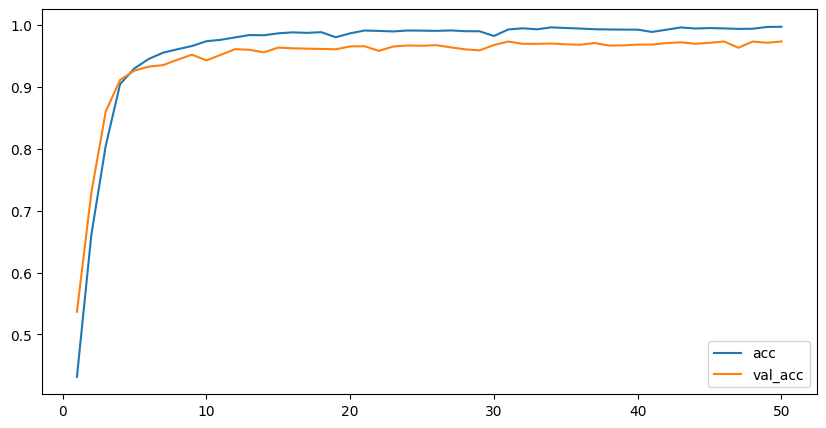

In [104]:
# 학습 현황 시각화 해보기
plt.figure( figsize = (10,5)) # 창 크기 설정
plt.plot(range(1,51) , h1.history['accuracy'] , label = 'acc')
plt.plot(range(1,51) , h1.history['val_accuracy'] , label = 'val_acc')
plt.legend()
plt.show()

In [110]:
# 예측
# X_test2 (2차원 -> 1차원)
# 1번째 이미지 예측하게 하기, 학습된 이미지의 크기에 맞춰서 데이터 연결
predict = model_mlp.predict(X_test2[1:2])
print(predict)  # 결과는 배열 형태로!
print('예측한 숫자' , predict.argmax())
print('실제라벨' , y_test[1])  # 실제 라벨이 담긴 친구를 써보기
#  예측을 잘 하고 있는것을 볼 수 있음!

1/1 [==============================] - 0s 19ms/step
[[2.7094572e-18 3.6153277e-16 1.0000000e+00 1.6753962e-20 1.3071999e-22
  1.7989177e-22 8.9677502e-21 6.1318307e-12 4.1147204e-13 1.1347060e-22]]
예측한 숫자 2
실제라벨 2


#### 직접 쓴 숫자를 인식시켜보자
- gradio라는 모듈을 사용 =>  실시간으로 서버와 모델을 연동하는 모듈(Library)
- 편리한 인터페이스를 제공하기 때문에 활용해보자

In [111]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [119]:
import gradio as gr
# gr.interface(fn = 예측하는 함수, inputs = gr.Sketchpad(brush_radius = 0.5 브러쉬 두께, outputs = 'label' ) <= 그림을 그릴 수 있는 패드가 나옴).launch()
def recognition(img):
  img = img.reshape(-1, 784)
  pred = model_mlp.predict(img)
  result = pred.argmax()  #  최댓값을 가진 인덱스 반환
  return f'{result}'

gr.Interface(fn = recognition, inputs = gr.Sketchpad(brush_radius = 0.5), 
             outputs = 'label').launch()






Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

CNN 모델설계 해보기

In [125]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D ,InputLayer,Flatten

In [127]:
# cnn + mlp => cnn모델
# mlp : 위치에 민감 ,숫자 크기에 민감
# cnn : 이미지 안에 있는 중요 부위에만 추출해서 학습에 적용하게 하는 기능
# 위치에 덜 민감해짐, 크기에 덜 민감해짐 => 예측정확도, 성능이 올라감

# 신경망 생성
model_cnn = Sequential() # 뼈대 구축

# 입력층
# 2차원 데이터 입력받음 => cnn 사용
# 행, 열, 색감정보(흑백 : 1 , rgb 컬러 : 3)를 input 정보에 알려줘야함
model_cnn.add(InputLayer(input_shape = (28,28,1)))

# cnn cmd - 특성추출부
# 커널, 필터 => 32개 정도 설정 -> 주요 부분을 출력하기 위한 연산 작용 연결
model_cnn.add(Conv2D(32,kernel_size =(4,4) , padding ='same',activation ='relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))  # Conv2D랑 세트임

model_cnn.add(Conv2D(64,kernel_size =(4,4) , padding ='same',activation ='relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))

# 지금 여기서 위에서 2차원으로 내려오고 있음 이걸 우리는 1차원으로 풀어줘야함
# mlp층(전결합층, 완전연결층) 연결 - 예측부
model_cnn.add(Flatten())
# cnn을 거치고 나서 mlp층은 중간층을 얕게 쌓는 특징이 있음
model_cnn.add(Dense(128, activation = 'relu'))

# 출력층
model_cnn.add(Dense(10,activation = 'softmax'))

# 신경망 구조 확인
model_cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_32 (Dense)            (None, 128)             

In [131]:
#  학습/평가 방법 설정
model_cnn.compile(loss = 'categorical_crossentropy',
                  optimizer  = 'adam',
                  metrics = ['accuracy'])


In [132]:
#  gkrtmq
h2 = model_cnn.fit(X_train, y_train_oh, validation_split=0.3,
                   epochs = 50, batch_size = 256)

Epoch 1/50
165/165 [==============================] - 11s 14ms/step - loss: 2.0242 - accuracy: 0.8683 - val_loss: 0.1056 - val_accuracy: 0.9676
Epoch 2/50
165/165 [==============================] - 3s 17ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.0829 - val_accuracy: 0.9757
Epoch 3/50
165/165 [==============================] - 3s 21ms/step - loss: 0.0481 - accuracy: 0.9844 - val_loss: 0.0665 - val_accuracy: 0.9812
Epoch 4/50
165/165 [==============================] - 4s 27ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0700 - val_accuracy: 0.9797
Epoch 5/50
165/165 [==============================] - 2s 14ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0712 - val_accuracy: 0.9809
Epoch 6/50
165/165 [==============================] - 2s 12ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0935 - val_accuracy: 0.9766
Epoch 7/50
165/165 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0628 - val_accuracy: 0.984

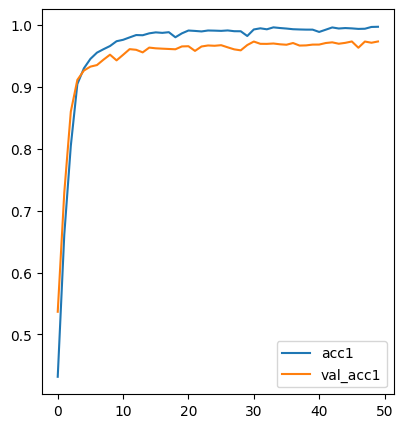

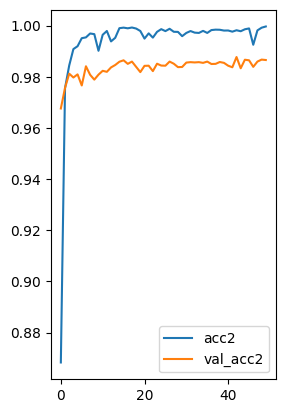

In [142]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)  # 하나의 행에 두개 출력할껀데 이게 첫번째다
plt.plot(h1.history['accuracy'] , label = 'acc1')
plt.plot(h1.history['val_accuracy'] , label = 'val_acc1')
plt.legend()
plt.show()

plt.subplot(1,2,2) # 하나의 행에 두개 출력할껀데 이게 두번째다
plt.plot(h2.history['accuracy'] , label = 'acc2')
plt.plot(h2.history['val_accuracy'] , label = 'val_acc2')
plt.legend()
plt.show()

In [145]:
import gradio as gr
# gr.interface(fn = 예측하는 함수, inputs = gr.Sketchpad(brush_radius = 0.5 브러쉬 두께, outputs = 'label' ) <= 그림을 그릴 수 있는 패드가 나옴).launch()
def recognition(img):
  img = img.reshape((1,28,28))
  pred = model_cnn.predict(img)
  result = pred.argmax()  #  최댓값을 가진 인덱스 반환
  return f'{result}'

gr.Interface(fn = recognition, inputs = gr.Sketchpad(brush_radius = 0.5), 
             outputs = 'label').launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
# 결과 -> cnn 모델 특성 추출부를 잘 성정해서 성능을 높혀야겠다!